In [1]:
import sys
import csv
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

import gender_guesser.detector as gender

from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier  # Import AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
def read_datasets():
    """ Reads users profile from csv files """
    real_users = pd.read_csv("users.csv")
    fake_users = pd.read_csv("fusers.csv")
    
    x = pd.concat([real_users,fake_users])    
    y = len(fake_users)*[0] + len(real_users)*[1]
    
    return x,y

In [3]:
def predict_sex(name):
    d = gender.Detector(case_sensitive=False)
    first_name= str(name).split(' ')[0]
    sex = d.get_gender(u"{}".format(first_name))
    
    sex_code_dict = {'female': -2, 'mostly_female': -1,'unknown':0, 'andy': 0, 'mostly_male':1, 'male': 2}
    code = sex_code_dict[sex]
    
    return code

In [4]:
def extract_features(x):
    lang_list = list(enumerate(np.unique(x['lang'])))
    
    lang_dict = { name : i for i, name in lang_list }             
    
    x.loc[:,'lang_code'] = x['lang'].map( lambda x: lang_dict[x]).astype(int)    
    x.loc[:,'sex_code'] = predict_sex(x['name'])
    
    feature_columns_to_use = ['statuses_count','followers_count','friends_count','favourites_count','listed_count','sex_code','lang_code']
    x = x.loc[:,feature_columns_to_use]
    
    return x

In [5]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    
    return plt

In [6]:
def plot_confusion_matrix(cm, title='CONFUSION MATRIX', cmap=plt.cm.Reds):
    target_names=['Fake','Genuine']
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [7]:
def train_with_adaboost(X_train, y_train, X_test):
    """ Trains and predicts dataset with an AdaBoost classifier """
    # Scaling features
    X_train = preprocessing.scale(X_train)
    X_test = preprocessing.scale(X_test)

    base_estimator = SVC(probability=True, kernel='linear')
    
    n_estimators = [50, 100, 200]
    learning_rate = [0.01, 0.1, 1.0]
    
    param = {'n_estimators': n_estimators, 'learning_rate': learning_rate}

    cvk = StratifiedKFold(n_splits=5)

    classifier = AdaBoostClassifier(base_estimator=base_estimator)

    clf = GridSearchCV(classifier, param_grid=param, cv=cvk)
    clf.fit(X_train, y_train)

    print("The best classifier is: ", clf.best_estimator_)
    clf.best_estimator_.fit(X_train, y_train)

    print()

    # Estimate score
    scores = cross_val_score(clf.best_estimator_, X_train, y_train, cv=5)
    
    print('Estimated score: %0.5f (+/- %0.5f)' % (scores.mean(), scores.std() / 2))

    title = 'Learning Curves (AdaBoost)'

    plot_learning_curve(clf.best_estimator_, title, X_train, y_train, cv=5)
    plt.show()

    # Predict class
    y_pred = clf.best_estimator_.predict(X_test)

    return y_pred

In [8]:
x, y = read_datasets()
print("dataset read complete")

dataset read complete


In [9]:
x = extract_features(x)
print(x.columns)

Index(['statuses_count', 'followers_count', 'friends_count',
       'favourites_count', 'listed_count', 'sex_code', 'lang_code'],
      dtype='object')


In [10]:
# splitting train and test data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.40, random_state=44)

In [11]:
y_pred_adaboost = train_with_adaboost(X_train, y_train, X_test)


C:\Users\ghanc\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\ghanc\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\ghanc\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\ghanc\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\ghanc\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` 

The best classifier is:  AdaBoostClassifier(base_estimator=SVC(kernel='linear', probability=True),
                   learning_rate=0.1)


C:\Users\ghanc\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


C:\Users\ghanc\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\ghanc\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\ghanc\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\ghanc\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\ghanc\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` 

Estimated score: 0.90533 (+/- 0.00504)


C:\Users\ghanc\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\ghanc\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\ghanc\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Confusion matrix for AdaBoost, without normalization
[[241  27]
 [ 29 267]]


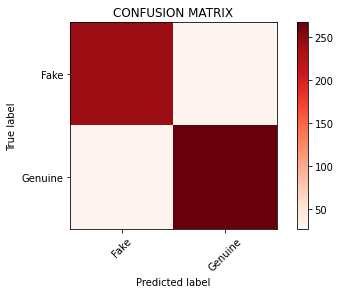

In [ ]:
confusionMatrixAdaBoost = confusion_matrix(y_test, y_pred_adaboost)
print('Confusion matrix for AdaBoost, without normalization')
print(confusionMatrixAdaBoost)
plot_confusion_matrix(confusionMatrixAdaBoost)

In [ ]:
print(classification_report(y_test, y_pred_adaboost, target_names=['Fake', 'Genuine']))


              precision    recall  f1-score   support

        Fake       0.89      0.90      0.90       268
     Genuine       0.91      0.90      0.91       296

    accuracy                           0.90       564
   macro avg       0.90      0.90      0.90       564
weighted avg       0.90      0.90      0.90       564



In [ ]:
print('Classification Accuracy on Test dataset (AdaBoost):', accuracy_score(y_test, y_pred_adaboost))

Classification Accuracy on Test dataset (AdaBoost): 0.900709219858156
